In [1]:
from typing import Union

import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
np.random.seed(0) # set random seed

nos = 50000            # number of valid simulations 
nob = 10000             # number of burn-in 
nod = 1                # consider every nod-th draw (thin value) 
simulations = nod*nos+nob

beta_lb = 1
beta = np.array([0, 1.5, 0, 0])
nop = 5

In [3]:
def load_data(nr=2, data_folder='data', vars=None):
    if vars is None:
        vars = ['sales', 'displ', 'coupon', 'price']

    data = {var: pd.read_excel(f'{data_folder}/{var}.xls')[f'brand{nr}'] for var in vars}
    df = pd.concat(data, axis = 1)

    df['logsales'] = np.log(df['sales'])
    df['logprice'] = np.log(df['price'])
    df['const'] = 1

    return df

In [4]:
def sigma_conditional(beta, y, X):
    res = y - X @ beta                  # residuals
    u = np.random.normal(size=len(y))   # random draws
    sigma2 = res.T @ res / (u.T @ u)    # simulate sigma^2
    return sigma2


In [5]:
def beta_conditional(sigma2, y, X):
    bcov = np.linalg.inv(X.T @ X)               # (X'X)^{-1}
    bhat = bcov @ X.T @ y                       # OLS estimate
    stdev = np.linalg.cholesky(sigma2 * bcov)   # Sigma^{-1/2}
    

    beta = bhat + stdev @ np.random.normal(size=bhat.size) # simulate beta
    return beta


In [6]:
def restric_beta_conditional(sigma2, y, X, lb: Union[int, float]=None, ub: Union[int, float]=None):
    bcov = np.linalg.inv(X.T @ X)[0][0]              # (X'X)^{-1}
    bhat = bcov * X.T @ y                       # OLS estimate
    stdev = np.sqrt(sigma2 * bcov)   # Sigma^{-1/2}
    
    if (lb is not None or ub is not None) and bhat.size != 1:
        raise Exception('Only one restricted parameter at a time.')

    min = norm.cdf((lb - bhat) / stdev) if lb is not None else 0
    max = norm.cdf((ub - bhat) / stdev) if ub is not None else 1

    beta = bhat + stdev * norm.ppf(min + (max - min) * np.random.uniform())

    return beta

In [7]:
def sample_param(df, beta, sigma2):
    mask = np.ones(beta.shape, bool)
    mask[1] = False

    y = df['logsales']
    X = df[['const', 'displ', 'coupon', 'logprice']]
    sigma2 = sigma_conditional(beta, y, X)

    y = df['logsales'] - beta[1] * df['displ']
    X = df[['const', 'coupon', 'logprice']]
    beta[mask] = beta_conditional(sigma2, y, X)

    y = df['logsales'] - (beta[0] * df['const'] + beta[2] * df['coupon'] + beta[3] * df['logprice']) 
    X = df[['displ']]
    beta[~mask] = restric_beta_conditional(sigma2, y, X, lb=beta_lb)

    return beta, sigma2

In [8]:
def get_draws(nr, beta=None, sigma2 = 1):
    if beta is None:
        beta=np.array([0, 1.5, 0, 0])
        
    df = load_data(nr)
    drawpar = np.zeros((simulations, nop))

    for i in range(simulations):
        print(i) if i % 1000 == 0 else None
        beta, sigma2 = sample_param(df, beta, sigma2)
        drawpar[i] = [*beta, sigma2]
    
    # remove bur-in draws and apply thinning
    drawpar = drawpar[nob:]
    drawpar = drawpar[range(0,nos*nod,nod)]
    
    return drawpar


In [9]:
def statistics(draws):
    median = np.median(draws, axis=0)
    tenp = np.percentile(draws, 10, axis=0)
    ninetyp = np.percentile(draws, 90, axis=0)

    stats = [tenp, median, ninetyp]
    return stats

In [10]:
def get_answers(nr):
    ans = ['', '', '', '', nr, beta_lb, 'Python 3', simulations, nob, nod]
    draws = get_draws(nr) # beta=beta
    stats = statistics(draws)
    for i in range(nop):
        for stat in stats:
            ans.append(stat[i])

    ans.append(np.mean(np.log(draws[:, 4])))
    return ans

In [11]:
import csv
import pdfrw

ANNOT_KEY = '/Annots'
ANNOT_FIELD_KEY = '/T'
ANNOT_VAL_KEY = '/V'
ANNOT_RECT_KEY = '/Rect'
SUBTYPE_KEY = '/Subtype'
WIDGET_SUBTYPE_KEY = '/Widget'

template = "answeringsheet.pdf"

def fill(nr, ans):
        iter_ans = iter(ans)
        template_pdf = pdfrw.PdfReader(template)

        for page in template_pdf.pages:
            annotations = page[ANNOT_KEY]
            for annotation in annotations:
                if annotation[SUBTYPE_KEY] == WIDGET_SUBTYPE_KEY:
                    if annotation[ANNOT_FIELD_KEY]:
                        key = annotation[ANNOT_FIELD_KEY][1:-1]
                        # print(key)
                        # print(next(reader))
                        annotation.update(
                                    pdfrw.PdfDict(V='{}'.format(next(iter_ans, '')))
                                )
                        annotation.update(pdfrw.PdfDict(AP=''))
        template_pdf.Root.AcroForm.update(pdfrw.PdfDict(NeedAppearances=pdfrw.PdfObject('true')))
        pdfrw.PdfWriter().write(f"./answers/answeringsheet{nr}.pdf", template_pdf)

In [69]:
draws = get_draws(2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000


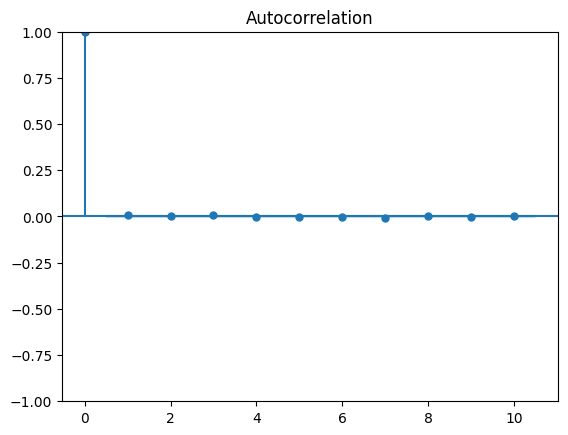

In [70]:
import matplotlib.pyplot as  plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(draws[:,0],lags=10)
plt.show()

In [71]:
from proc import gewtest
from tabulate import tabulate

# Geweke test
table=np.column_stack((['beta0', 'beta1', 'beta2', 'beta3', 'sigma^2'], gewtest(draws)))
headers=["parameter","mean 1","mean 2","st dev","test statistic","p-value"]
table = tabulate(table, headers, tablefmt="fancy_grid")
print("Geweke convergence test (non-HAC variances)")
print(table)

Geweke convergence test (non-HAC variances)
╒═════════════╤════════════╤════════════╤═════════════╤══════════════════╤════════════╕
│ parameter   │     mean 1 │     mean 2 │      st dev │   test statistic │    p-value │
╞═════════════╪════════════╪════════════╪═════════════╪══════════════════╪════════════╡
│ beta0       │  3.86425   │  3.85591   │ 0.00340169  │        2.45388   │ 0.00706617 │
├─────────────┼────────────┼────────────┼─────────────┼──────────────────┼────────────┤
│ beta1       │  1.05102   │  1.05196   │ 0.000728048 │       -1.28613   │ 0.0991982  │
├─────────────┼────────────┼────────────┼─────────────┼──────────────────┼────────────┤
│ beta2       │  0.0352063 │  0.0388996 │ 0.00295804  │       -1.24857   │ 0.105912   │
├─────────────┼────────────┼────────────┼─────────────┼──────────────────┼────────────┤
│ beta3       │ -1.67317   │ -1.65902   │ 0.0111911   │       -1.26434   │ 0.103054   │
├─────────────┼────────────┼────────────┼─────────────┼──────────────────┼──

In [12]:
for i in range(1, 101):
    try:
        fill(i, get_answers(i))
    except:
        continue

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
